# SageMaker/DeepAR demo on electricity dataset

This notebook complements the [DeepAR introduction notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_synthetic/deepar_synthetic.ipynb). 

Here, we will consider a real use case and show how to use DeepAR on SageMaker for predicting energy consumption of 370 customers over time, based on a [dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) that was used in the academic papers [[1](https://media.nips.cc/nipsbooks/nipspapers/paper_files/nips29/reviews/526.html)] and [[2](https://arxiv.org/abs/1704.04110)].  

In particular, we will see how to:
* Prepare the dataset
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively
* Illustrate advanced features of DeepAR: missing values, additional time features, non-regular frequencies and category information

Running this notebook takes around 40 min on a ml.c4.2xlarge for the training, and inference is done on a ml.m5.large (the usage time will depend on how long you leave your served model running).

This notebook is tested using SageMaker Studio but using classic Notebook (From the SageMaker Menu, go to Help -> select `Launch Classic Notebook`). 

For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) or [paper](https://arxiv.org/abs/1704.04110), 

In [1]:
import sys
!{sys.executable} -m pip install s3fs

     |████████████████████████████████| 7.4 MB 38.2 MB/s eta 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.22.3
    Uninstalling botocore-1.22.3:
      Successfully uninstalled botocore-1.22.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.19.3 requires botocore<1.23.0,>=1.22.3, but you have botocore 1.20.49 which is incompatible.
awscli 1.21.3 requires botocore==1.22.3, but you have botocore 1.20.49 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
from __future__ import print_function
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [42]:
!conda install -c conda-forge ipywidgets -y -q

Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/noarch::typing-extensions==3.7.4.3=0
  - conda-forge/linux-64::pluggy==0.13.1=py36h5fab9bb_4
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::path.py==12.5.0=0
  - conda-forge/noarch::qdarkstyle==2.8.1=pyhd8ed1ab_2
  - conda-forge/noarch::ipywidgets==7.6.3=pyhd3deb0d_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-fo

In [2]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [3]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [4]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'deepar-electricity-demo-notebook'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [5]:
region = sagemaker_session.boto_region_name

s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

Next, we configure the container image to be used for the region that we are running in.

In [6]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar",region)

In [7]:
image_name

'522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1'

### Import electricity dataset and upload it to S3 to make it available for Sagemaker

As a first step, we need to download the original data set of from the UCI data set repository.

In [8]:
DATA_HOST = "https://archive.ics.uci.edu"
DATA_PATH = "/ml/machine-learning-databases/00321/"
ARCHIVE_NAME = "LD2011_2014.txt.zip"
FILE_NAME = ARCHIVE_NAME[:-4]

In [9]:
def progress_report_hook(count, block_size, total_size):
    mb = int(count * block_size // 1e6)
    if count % 500 == 0:
        sys.stdout.write("\r{} MB downloaded".format(mb))
        sys.stdout.flush()

if not os.path.isfile(FILE_NAME):
    print("downloading dataset (258MB), can take a few minutes depending on your connection")
    urlretrieve(DATA_HOST + DATA_PATH + ARCHIVE_NAME, ARCHIVE_NAME, reporthook=progress_report_hook)

    print("\nextracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_NAME, 'r')
    zip_ref.extractall("./")
    zip_ref.close()
else:
    print("File found skipping download")

File found skipping download


Then, we load and parse the dataset and convert it to a collection of Pandas time series, which makes common time series operations such as indexing by time periods or resampling much easier. The data is originally recorded in 15min interval, which we could use directly. Here we want to forecast longer periods (one week) and resample the data to a granularity of 2 hours.

In [10]:
data = pd.read_csv(FILE_NAME, sep=";", index_col=0, parse_dates=True, decimal=',')
num_timeseries = data.shape[1]
data_kw = data.resample('2H').sum() / 8
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

Let us plot the resulting time series for the first ten customers for the time period spanning the first two weeks of 2014.

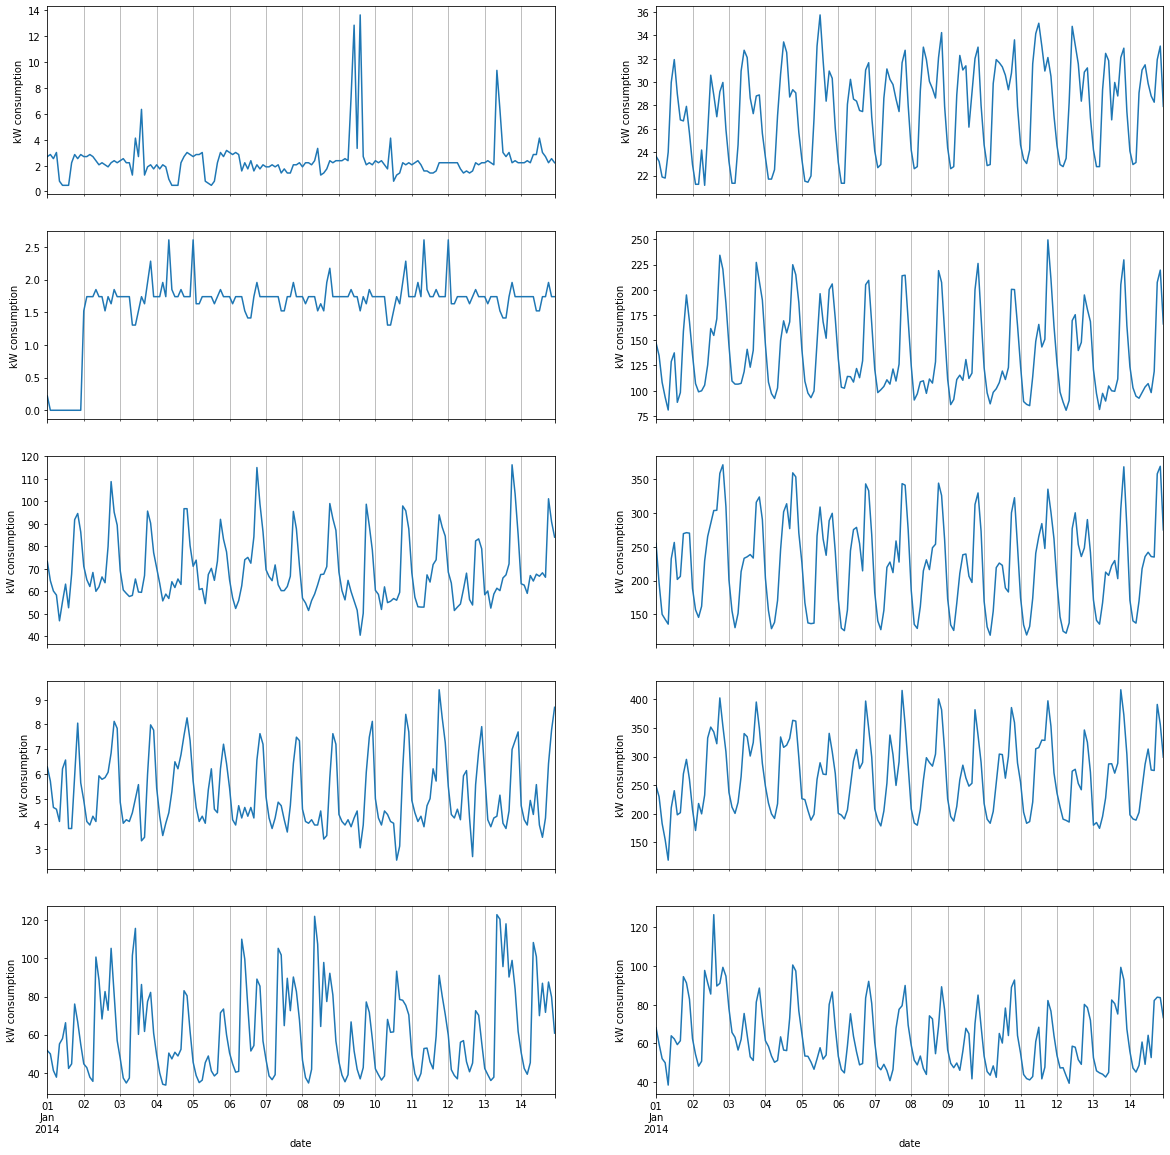

In [11]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [12]:
# we use 2 hour frequency for the time series
freq = '2H'

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

We specify here the portion of the data that is used for training: the model sees data from 2014-01-01 to 2014-09-01 for training.

In [13]:
start_dataset = pd.Timestamp("2014-01-01 00:00:00", freq=freq)
end_training = pd.Timestamp("2014-09-01 00:00:00", freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [14]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - timedelta(days=1)].tolist()  
    }
    for ts in timeseries
]
print(len(training_data))

370


As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.
To evaluate our model performance on more than one week, we generate test data that extends to 1, 2, 3, 4 weeks beyond the training range. This way we perform *rolling evaluation* of our model.

In [15]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training + timedelta(days=k * prediction_length)].tolist()
    }
    for k in range(1, num_test_windows + 1) 
    for ts in timeseries
]
print(len(test_data))

1480


Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [16]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [17]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 4.71 s, sys: 188 ms, total: 4.9 s
Wall time: 5.15 s


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes.

In [18]:
!aws s3 cp train.json {s3_data_path}/train/train.json
!aws s3 cp test.json {s3_data_path}/test/test.json

upload: ./train.json to s3://sagemaker-us-east-1-431615879134/deepar-electricity-demo-notebook/data/train/train.json
upload: ./test.json to s3://sagemaker-us-east-1-431615879134/deepar-electricity-demo-notebook/data/test/test.json


Let's have a look to what we just wrote to S3.

In [19]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:400] + "...")

{"start": "2014-01-01 00:00:00", "target": [2.6967005076142154, 2.8553299492385804, 2.53807106598985, 3.0139593908629454, 0.7931472081218263, 0.47588832487309496, 0.47588832487309496, 0.47588832487309496, 2.2208121827411174, 2.8553299492385804, 2.53807106598985, 2.8553299492385804, 2.696700507614215, 2.6967005076142154, 2.85532994923858, 2.6967005076142154, 2.379441624365483, 2.06218274111675, 2.2...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [26]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    base_job_name='deepar-electricity-demo',
    output_path=s3_output_path
)

Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [27]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [28]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [29]:
%%time
data_channels = {
    "train": f"{s3_data_path}/train/",
    "test": f"{s3_data_path}/test/"
}

estimator.fit(inputs=data_channels, wait=True)

2021-11-02 15:17:43 Starting - Starting the training job...
2021-11-02 15:18:06 Starting - Launching requested ML instancesProfilerReport-1635866262: InProgress
......
2021-11-02 15:19:07 Starting - Preparing the instances for training.........
2021-11-02 15:20:37 Downloading - Downloading input data...
2021-11-02 15:21:07 Training - Training image download completed. Training in progress..Arguments: train
[11/02/2021 15:21:12 INFO 140323713336704] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [30]:
from sagemaker.serializers import IdentitySerializer

In [31]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         #serializer=JSONSerializer(),
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [32]:
estimator = estimator.attach('deepar-electricity-demo-2021-05-07-15-52-10-057')


2021-05-07 16:08:42 Starting - Preparing the instances for training
2021-05-07 16:08:42 Downloading - Downloading input data
2021-05-07 16:08:42 Training - Training image download completed. Training in progress.
2021-05-07 16:08:42 Uploading - Uploading generated training model
2021-05-07 16:08:42 Completed - Training job completed


In [33]:
%%time
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

------!

### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

In [20]:
predictor.predict(ts=timeseries[120], quantiles=[0.10, 0.5, 0.90]).head()

NameError: name 'predictor' is not defined

Below we define a plotting function that queries the model and displays the forecast.

In [21]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    freq = target_ts.index.freq
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date - plot_history * freq:forecast_date + prediction_length * freq]
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date - plot_history * freq:forecast_date + prediction_length * freq].plot(ax=ax, color='g')

We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [22]:
style = {'description_width': 'initial'}

In [23]:
customer_id = 91
forecast_day=52
plot_history=3
confidence = 80

In [24]:
plot(predictor,
     target_ts=timeseries[customer_id],
     forecast_date=end_training + datetime.timedelta(days=forecast_day),
     show_samples=False,
     plot_history=plot_history * 12 * 7,
     confidence=confidence
    )

NameError: name 'predictor' is not defined

In [25]:
@interact_manual(
    customer_id=IntSlider(min=0, max=369, value=91, style=style), 
    forecast_day=IntSlider(min=0, max=100, value=51, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_weeks_plot=IntSlider(min=1, max=20, value=1, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, forecast_day, confidence, history_weeks_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[customer_id],
        forecast_date=end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_weeks_plot * 12 * 7,
        confidence=confidence
    )

interactive(children=(IntSlider(value=91, description='customer_id', max=369, style=SliderStyle(description_wi…

# Additional features

We have seen how to prepare a dataset and run DeepAR for a simple example.

In addition DeepAR supports the following features:

* missing values: DeepAR can handle missing values in the time series during training as well as for inference.
* Additional time features: DeepAR provides a set default time series features such as hour of day etc. However, you can provide additional feature time series via the `dynamic_feat` field. 
* generalize frequencies: any integer multiple of the previously supported base frequencies (minutes `min`, hours `H`, days `D`, weeks `W`, month `M`) are now allowed; e.g., `15min`. We already demonstrated this above by using `2H` frequency.
* categories: If your time series belong to different groups (e.g. types of product, regions, etc), this information can be encoded as one or more categorical features using the `cat` field.

We will now demonstrate the missing values and time features support. For this part we will reuse the electricity dataset but will do some artificial changes to demonstrate the new features: 
* We will randomly mask parts of the time series to demonstrate the missing values support.
* We will include a "special-day" that occurs at different days for different time series during this day we introduce a strong up-lift
* We train the model on this dataset giving "special-day" as a custom time series feature

## Prepare dataset

As discussed above we will create a "special-day" feature and create an up-lift for the time series during this day. This simulates real world application where you may have things like promotions of a product for a certain time or a special event that influences your time series. 

In [34]:
def create_special_day_feature(ts, fraction=0.05):
    # First select random day indices (plus the forecast day)
    num_days = (ts.index[-1] - ts.index[0]).days
    rand_indices = list(np.random.randint(0, num_days, int(num_days * 0.1))) + [num_days]
    
    feature_value = np.zeros_like(ts)
    for i in rand_indices:
        feature_value[i * 12: (i + 1) * 12] = 1.0
    feature = pd.Series(index=ts.index, data=feature_value)
    return feature

def drop_at_random(ts, drop_probability=0.1):
    assert(0 <= drop_probability < 1)
    random_mask = np.random.random(len(ts)) < drop_probability
    return ts.mask(random_mask)

In [35]:
special_day_features = [create_special_day_feature(ts) for ts in timeseries]

We now create the up-lifted time series and randomly remove time points.

The figures below show some example time series and the `special_day` feature value in green. 

In [36]:
timeseries_uplift = [ts * (1.0 + feat) for ts, feat in zip(timeseries, special_day_features)]
time_series_processed = [drop_at_random(ts) for ts in timeseries_uplift]

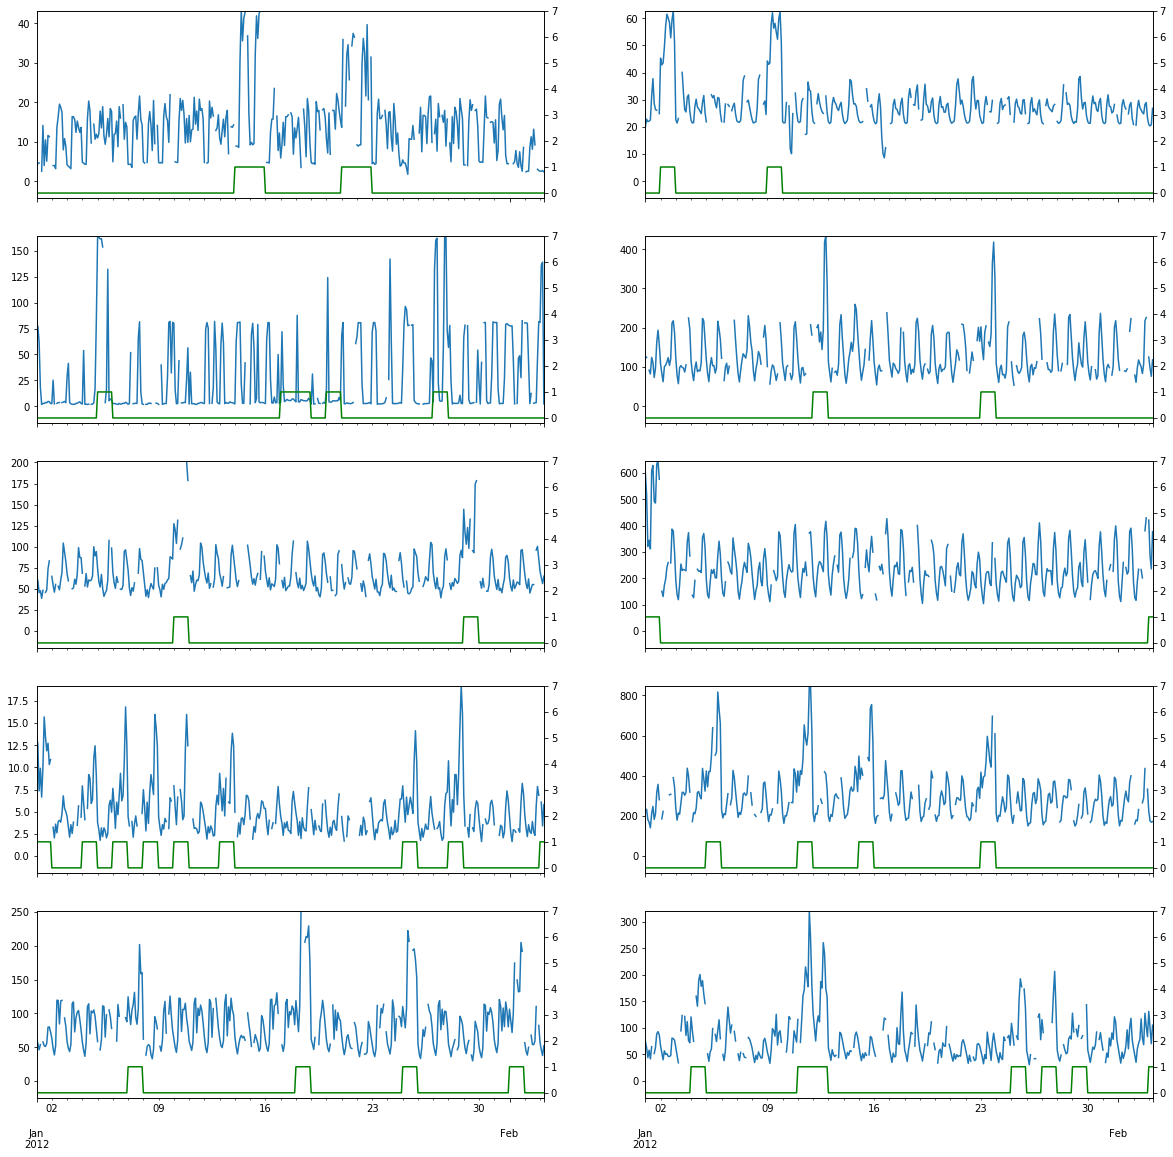

In [37]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    ax = axx[i]
    ts = time_series_processed[i][:400]
    ts.plot(ax=ax)
    ax.set_ylim(-0.1 * ts.max(), ts.max())
    ax2 = ax.twinx()
    special_day_features[i][:400].plot(ax=ax2, color='g')
    ax2.set_ylim(-0.2, 7)

In [38]:
%%time

training_data_new_features = [
    {
        "start": str(start_dataset),
        "target": encode_target(ts[start_dataset:end_training]),
        "dynamic_feat": [special_day_features[i][start_dataset:end_training].tolist()]
    }
    for i, ts in enumerate(time_series_processed)
]
print(len(training_data_new_features))

# as in our previous example, we do a rolling evaluation over the next 7 days
num_test_windows = 7

test_data_new_features = [
    {
        "start": str(start_dataset),
        "target": encode_target(ts[start_dataset:end_training + 2*k*prediction_length * ts.index.freq]),
        "dynamic_feat": [special_day_features[i][start_dataset:end_training + 2*k*prediction_length * ts.index.freq].tolist()]
    }
    for k in range(1, num_test_windows + 1) 
    for i, ts in enumerate(timeseries_uplift)
]

370
CPU times: user 15.4 s, sys: 402 ms, total: 15.8 s
Wall time: 15.8 s


In [39]:
def check_dataset_consistency(train_dataset, test_dataset=None):
    d = train_dataset[0]
    has_dynamic_feat = 'dynamic_feat' in d
    if has_dynamic_feat:
        num_dynamic_feat = len(d['dynamic_feat'])
    has_cat = 'cat' in d
    if has_cat:
        num_cat = len(d['cat'])
    
    def check_ds(ds):
        for i, d in enumerate(ds):
            if has_dynamic_feat:
                assert 'dynamic_feat' in d
                assert num_dynamic_feat == len(d['dynamic_feat'])
                for f in d['dynamic_feat']:
                    assert len(d['target']) == len(f)
            if has_cat:
                assert 'cat' in d
                assert len(d['cat']) == num_cat
    check_ds(train_dataset)
    if test_dataset is not None:
        check_ds(test_dataset)
        
check_dataset_consistency(training_data_new_features, test_data_new_features)

In [40]:
%%time
write_dicts_to_file("train_new_features.json", training_data_new_features)
write_dicts_to_file("test_new_features.json", test_data_new_features)

CPU times: user 7.08 s, sys: 416 ms, total: 7.5 s
Wall time: 9.38 s


In [41]:
%%time

s3_data_path_new_features = "s3://{}/{}-new-features/data".format(s3_bucket, s3_prefix)
s3_output_path_new_features = "s3://{}/{}-new-features/output".format(s3_bucket, s3_prefix)

print('Uploading to S3 this may take a few minutes depending on your connection.')
copy_to_s3("train_new_features.json", s3_data_path_new_features + "/train/train_new_features.json", override=True)
copy_to_s3("test_new_features.json", s3_data_path_new_features + "/test/test_new_features.json", override=True)

Uploading to S3 this may take a few minutes depending on your connection.
Uploading file to s3://sagemaker-us-east-1-431615879134/deepar-electricity-demo-notebook-new-features/data/train/train_new_features.json
Uploading file to s3://sagemaker-us-east-1-431615879134/deepar-electricity-demo-notebook-new-features/data/test/test_new_features.json
CPU times: user 748 ms, sys: 469 ms, total: 1.22 s
Wall time: 3.96 s


In [42]:
%%time
estimator_new_features = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    base_job_name='deepar-electricity-demo-new-features',
    output_path=s3_output_path_new_features
)

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "epochs": "400",
    "learning_rate": "5E-4",
    "mini_batch_size": "64",
    "early_stopping_patience": "40",
    "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
}
estimator_new_features.set_hyperparameters(**hyperparameters)

estimator_new_features.fit(
    inputs={
        "train": "{}/train/".format(s3_data_path_new_features),
        "test": "{}/test/".format(s3_data_path_new_features)
    }, 
    wait=True
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2021-03-01 18:28:02 Starting - Starting the training job...
2021-03-01 18:28:27 Starting - Launching requested ML instancesProfilerReport-1614623282: InProgress
......
2021-03-01 18:29:28 Starting - Preparing the instances for training......
2021-03-01 18:30:29 Downloading - Downloading input data
2021-03-01 18:30:29 Training - Downloading the training image....Arguments: train
[03/01/2021 18:31:03 INFO 140507249452864] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stoppin

As before, we spawn an endpoint to visualize our forecasts on examples we send on the fly.

In [43]:
%%time
predictor_new_features = estimator_new_features.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor)

---------------!CPU times: user 225 ms, sys: 9.92 ms, total: 235 ms
Wall time: 7min 32s


In [44]:
customer_id = 120
predictor_new_features.predict(
    ts=time_series_processed[customer_id][:-prediction_length], 
    dynamic_feat=[special_day_features[customer_id].tolist()], 
    quantiles=[0.1, 0.5, 0.9]
).head()

,0.1,0.9,0.5
2014-12-25 02:00:00,213.615906,250.916168,234.116074
2014-12-25 04:00:00,193.267502,232.315536,211.241287
2014-12-25 06:00:00,190.430832,231.860931,205.023315
2014-12-25 08:00:00,238.762527,286.625977,261.721497
2014-12-25 10:00:00,239.071609,283.223450,263.906158


As before, we can query the endpoint to see predictions for arbitrary time series and time points.

In [45]:
@interact_manual(
    customer_id=IntSlider(min=0, max=369, value=13, style=style), 
    forecast_day=IntSlider(min=0, max=100, value=21, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    missing_ratio=FloatSlider(min=0.0, max=0.95, value=0.2, step=0.05, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, forecast_day, confidence, missing_ratio, show_samples): 
    forecast_date = end_training + datetime.timedelta(days=forecast_day)
    ts = time_series_processed[customer_id]
    freq = ts.index.freq
    target = ts[start_dataset:forecast_date + prediction_length * freq]
    target = drop_at_random(target, missing_ratio)
    dynamic_feat = [special_day_features[customer_id][start_dataset:forecast_date + prediction_length * freq].tolist()]
    plot(
        predictor_new_features,
        target_ts=target, 
        dynamic_feat=dynamic_feat,
        forecast_date=forecast_date,
        show_samples=show_samples, 
        plot_history=7*12,
        confidence=confidence
    )

interactive(children=(IntSlider(value=13, description='customer_id', max=369, style=SliderStyle(description_wi…

### Delete endpoints

In [ ]:
predictor.delete_endpoint()

In [ ]:
predictor_new_features.delete_endpoint()